# 실습 과제 1.
Lab 3 CNN MNIST 실습에서 Dropout 을 추가하기 전과 후의 모델을 각각
학습시키고 결과를 논의하세요.

dropout있는 버전

100%|██████████| 9912422/9912422 [00:00<00:00, 160267800.67it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 34541116.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48394350.15it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 8455627.50it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Batch 200, Loss: 0.486, Accuracy: 84.58%
Epoch 1, Batch 400, Loss: 0.179, Accuracy: 94.59%
Epoch 1, Batch 600, Loss: 0.140, Accuracy: 95.88%
Epoch 1, Batch 800, Loss: 0.124, Accuracy: 96.50%
Epoch 2, Batch 200, Loss: 0.096, Accuracy: 97.14%
Epoch 2, Batch 400, Loss: 0.097, Accuracy: 97.27%
Epoch 2, Batch 600, Loss: 0.091, Accuracy: 97.50%
Epoch 2, Batch 800, Loss: 0.087, Accuracy: 97.38%
Epoch 3, Batch 200, Loss: 0.075, Accuracy: 97.88%
Epoch 3, Batch 400, Loss: 0.065, Accuracy: 97.98%
Epoch 3, Batch 600, Loss: 0.071, Accuracy: 97.85%
Epoch 3, Batch 800, Loss: 0.070, Accuracy: 97.96%
Epoch 4, Batch 200, Loss: 0.052, Accuracy: 98.50%
Epoch 4, Batch 400, Loss: 0.060, Accuracy: 98.38%
Epoch 4, Batch 600, Loss: 0.063, Accuracy: 98.09%
Epoch 4, Batch 800, Loss: 0.057, Accuracy: 98.23%
Epoch 5, Batch 200, Loss: 0.052, Accuracy: 98.34%
Epoch 5, Batch 400, Loss: 0.049, Accuracy: 98.47%
Epoch 5, Batch 600, Loss: 0.044, Accuracy: 98.68%
Epoch 5, Batch 800, Loss: 0.051, Accuracy: 98.45%


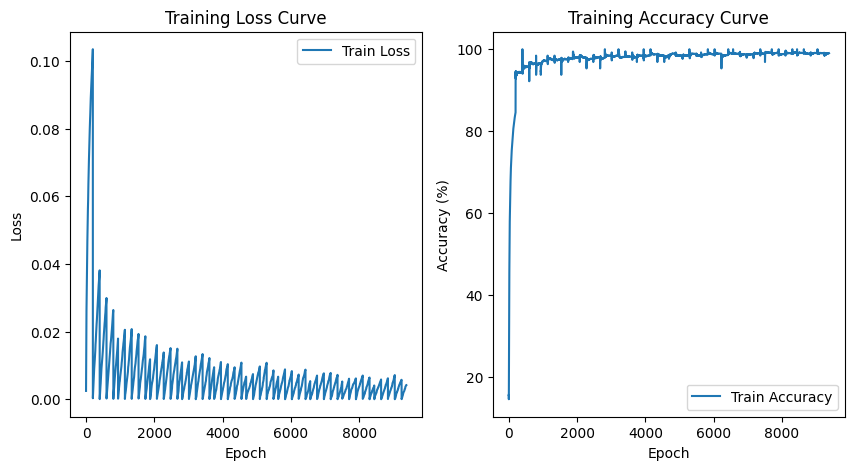

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import time

# Step 1: Define the transformations and load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
#net = Net()

# Step 3: Define a Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Prepare to collect data for analysis
train_losses = []
train_accuracies = []
epoch_times = []

# Step 4: Train the Network
for epoch in range(10):  # loop over the dataset multiple times
    epoch_start = time.time()
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        epoch_times.append(time.time() - epoch_start)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if i % 200 == 199:  # print every 200 mini-batches
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 200:.3f}, Accuracy: {accuracy:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0

total_training_time = sum(epoch_times)
print(f'Total training time: {total_training_time:.2f} seconds')

print('Finished Training')

# Step 5: Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

#여기부터 추가된 부분

# Number of parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')

# Plotting the learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


dropout 없는버전

Epoch 1, Batch 200, Loss: 0.367, Accuracy: 88.88%
Epoch 1, Batch 400, Loss: 0.105, Accuracy: 96.71%
Epoch 1, Batch 600, Loss: 0.081, Accuracy: 97.54%
Epoch 1, Batch 800, Loss: 0.069, Accuracy: 97.90%
Epoch 2, Batch 200, Loss: 0.044, Accuracy: 98.73%
Epoch 2, Batch 400, Loss: 0.044, Accuracy: 98.70%
Epoch 2, Batch 600, Loss: 0.038, Accuracy: 98.88%
Epoch 2, Batch 800, Loss: 0.039, Accuracy: 98.91%
Epoch 3, Batch 200, Loss: 0.024, Accuracy: 99.19%
Epoch 3, Batch 400, Loss: 0.026, Accuracy: 99.14%
Epoch 3, Batch 600, Loss: 0.030, Accuracy: 99.05%
Epoch 3, Batch 800, Loss: 0.032, Accuracy: 99.03%
Epoch 4, Batch 200, Loss: 0.015, Accuracy: 99.48%
Epoch 4, Batch 400, Loss: 0.016, Accuracy: 99.51%
Epoch 4, Batch 600, Loss: 0.023, Accuracy: 99.26%
Epoch 4, Batch 800, Loss: 0.016, Accuracy: 99.44%
Epoch 5, Batch 200, Loss: 0.009, Accuracy: 99.70%
Epoch 5, Batch 400, Loss: 0.009, Accuracy: 99.68%
Epoch 5, Batch 600, Loss: 0.012, Accuracy: 99.57%
Epoch 5, Batch 800, Loss: 0.013, Accuracy: 99.58%


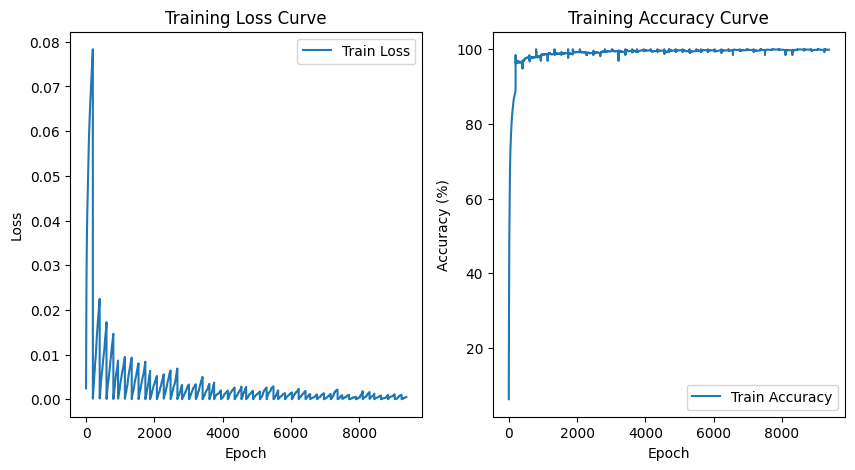

In [ ]:
# Step 1: Define the transformations and load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        #x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        #x = self.dropout2(x)
        x = self.fc2(x)
        output = nn.functional.log_softmax(x, dim=1)
        return output

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)
#net = Net()

# Step 3: Define a Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Prepare to collect data for analysis
train_losses = []
train_accuracies = []
epoch_times = []

# Step 4: Train the Network
for epoch in range(10):  # loop over the dataset multiple times
    epoch_start = time.time()
    running_loss = 0.0
    total = 0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct / total
        epoch_times.append(time.time() - epoch_start)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        if i % 200 == 199:  # print every 200 mini-batches
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 200:.3f}, Accuracy: {accuracy:.2f}%')
            running_loss = 0.0
            correct = 0
            total = 0

total_training_time = sum(epoch_times)
print(f'Total training time: {total_training_time:.2f} seconds')

print('Finished Training')

# Step 5: Test the network on the test data
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

#여기부터 추가된 부분

# Number of parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')

# Plotting the learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# 실습 과제 2.
Lab 3 CNN MNIST 실습에서 데이터셋을 CIFAR10으로 바꾸고 Global
Average Pooling를 추가하기 전과 후 모델을 각각 수정하여 약 1M 개의 파라미터로 학
습시키고 비교하여 결과를 논의하세요.


GAP 있는 버전

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Batch 200, Loss: 1.596, Accuracy: 40.82%
Epoch 1, Batch 400, Loss: 1.300, Accuracy: 52.48%
Epoch 1, Batch 600, Loss: 1.180, Accuracy: 57.55%
Epoch 2, Batch 200, Loss: 1.003, Accuracy: 64.32%
Epoch 2, Batch 400, Loss: 0.977, Accuracy: 64.79%
Epoch 2, Batch 600, Loss: 0.950, Accuracy: 65.89%
Epoch 3, Batch 200, Loss: 0.852, Accuracy: 69.73%
Epoch 3, Batch 400, Loss: 0.811, Accuracy: 70.95%
Epoch 3, Batch 600, Loss: 0.819, Accuracy: 70.52%
Epoch 4, Batch 200, Loss: 0.734, Accuracy: 73.52%
Epoch 4, Batch 400, Loss: 0.725, Accuracy: 73.98%
Epoch 4, Batch 600, Loss: 0.717, Accuracy: 74.74%
Epoch 5, Batch 200, Loss: 0.640, Accuracy: 77.19%
Epoch 5, Batch 400, Loss: 0.626, Accuracy: 78.07%
Epoch 5, Batch 600, Loss: 0.625, Accuracy: 78.24%
Epoch 6, Batch 200, Loss: 0.575, Accuracy: 79.96%
Epoch 6, Batch 400, Loss: 0.547, Accuracy: 80.62%
Epoch 6, Batch 600, Loss: 0.562, Accuracy: 80.40%
Epoch 7, Batch 200, Loss

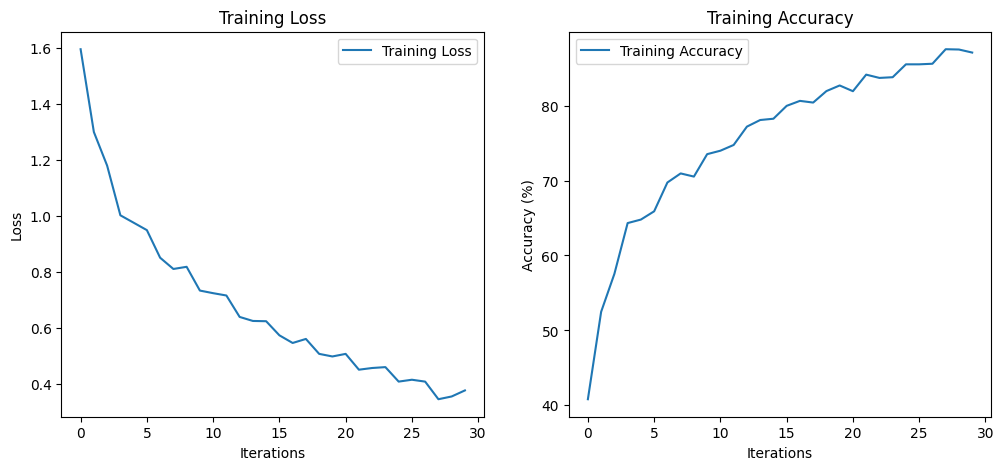

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize for 3 channels

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Adjust the CNN architecture to handle 3 channel input
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Prepare to collect data for analysis
epoch_durations = []
test_duration = 0

# Step 5: Train the network
train_losses = []
train_accuracy = []
start_time = time.time()

for epoch in range(10):
    epoch_start = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses.append(avg_loss)
            train_accuracy.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0
    epoch_durations.append(time.time() - epoch_start)

total_training_time = time.time() - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

# Step 6: Evaluate the network on the test data
test_start = time.time()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_duration = time.time() - test_start
print(f'Test Duration: {test_duration:.2f} seconds')
print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

# Number of parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params}')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

GAP 없는 버전

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Batch 200, Loss: 1.845, Accuracy: 35.69%
Epoch 1, Batch 400, Loss: 1.324, Accuracy: 52.16%
Epoch 1, Batch 600, Loss: 1.155, Accuracy: 58.41%
Epoch 2, Batch 200, Loss: 0.936, Accuracy: 66.96%
Epoch 2, Batch 400, Loss: 0.862, Accuracy: 69.44%
Epoch 2, Batch 600, Loss: 0.800, Accuracy: 71.96%
Epoch 3, Batch 200, Loss: 0.688, Accuracy: 75.79%
Epoch 3, Batch 400, Loss: 0.695, Accuracy: 76.16%
Epoch 3, Batch 600, Loss: 0.652, Accuracy: 76.98%
Epoch 4, Batch 200, Loss: 0.547, Accuracy: 80.72%
Epoch 4, Batch 400, Loss: 0.574, Accuracy: 79.76%
Epoch 4, Batch 600, Loss: 0.559, Accuracy: 80.52%
Epoch 5, Batch 200, Loss: 0.440, Accuracy: 84.85%
Epoch 5, Batch 400, Loss: 0.470, Accuracy: 83.38%
Epoch 5, Batch 600, Loss: 0.484, Accuracy: 83.29%
Epoch 6, Batch 200, Loss: 0.366, Accuracy: 87.31%
Epoch 6, Batch 400, Loss: 0.387, Accuracy: 86.29%
Epoch 6, Batch 600, Loss: 0.390, Accuracy: 86.61%
Epoch 7, Batch 200, Loss

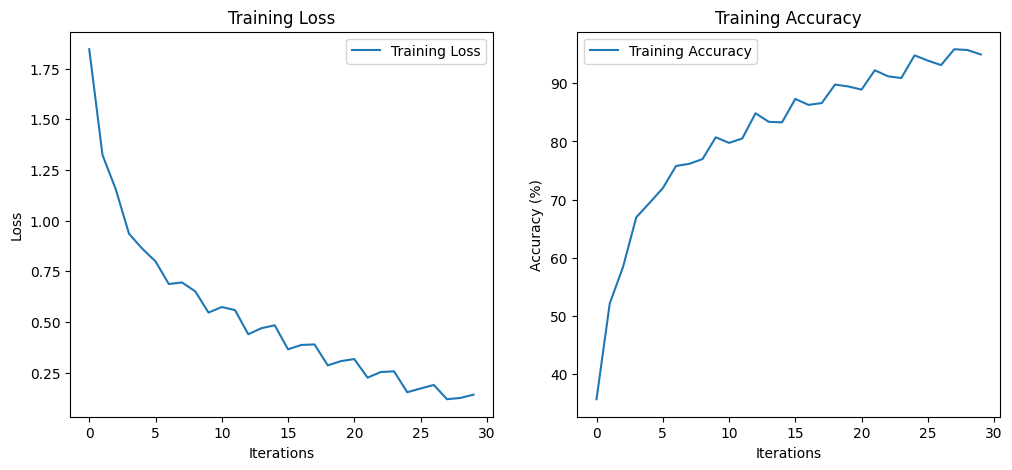

In [ ]:
# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize for 3 channels

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Adjust the CNN architecture to handle 3 channel input
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        #self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256*8*8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        #x = self.global_avg_pool(x)
        x = x.view(-1, 256*8*8)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Prepare to collect data for analysis
epoch_durations = []
test_duration = 0

# Step 5: Train the network
train_losses = []
train_accuracy = []
start_time = time.time()

for epoch in range(10):
    epoch_start = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses.append(avg_loss)
            train_accuracy.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0
    epoch_durations.append(time.time() - epoch_start)

total_training_time = time.time() - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

# Step 6: Evaluate the network on the test data
test_start = time.time()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_duration = time.time() - test_start
print(f'Test Duration: {test_duration:.2f} seconds')
print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

# Number of parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params}')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

#실습 과제 3.
위 실습 과제 2, GAP를 추가한 모델에서 BatchNorm을 추가하기 전과 후를
각각 학습시키고 결과를 논의하세요.


Batch normalization 적용 된 경우: 위의 경우와 동일할것 같아서 생략

Batch normalization 적용하지 않은 경우

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Batch 200, Loss: 2.023, Accuracy: 21.70%
Epoch 1, Batch 400, Loss: 1.717, Accuracy: 33.63%
Epoch 1, Batch 600, Loss: 1.506, Accuracy: 43.19%
Epoch 2, Batch 200, Loss: 1.262, Accuracy: 53.82%
Epoch 2, Batch 400, Loss: 1.197, Accuracy: 55.41%
Epoch 2, Batch 600, Loss: 1.137, Accuracy: 58.90%
Epoch 3, Batch 200, Loss: 1.027, Accuracy: 63.05%
Epoch 3, Batch 400, Loss: 0.991, Accuracy: 64.48%
Epoch 3, Batch 600, Loss: 0.945, Accuracy: 66.09%
Epoch 4, Batch 200, Loss: 0.878, Accuracy: 68.91%
Epoch 4, Batch 400, Loss: 0.847, Accuracy: 69.59%
Epoch 4, Batch 600, Loss: 0.828, Accuracy: 70.70%
Epoch 5, Batch 200, Loss: 0.756, Accuracy: 73.02%
Epoch 5, Batch 400, Loss: 0.740, Accuracy: 74.24%
Epoch 5, Batch 600, Loss: 0.735, Accuracy: 74.14%
Epoch 6, Batch 200, Loss: 0.654, Accuracy: 77.07%
Epoch 6, Batch 400, Loss: 0.662, Accuracy: 76.70%
Epoch 6, Batch 600, Loss: 0.634, Accuracy: 78.09%
Epoch 7, Batch 200, Loss

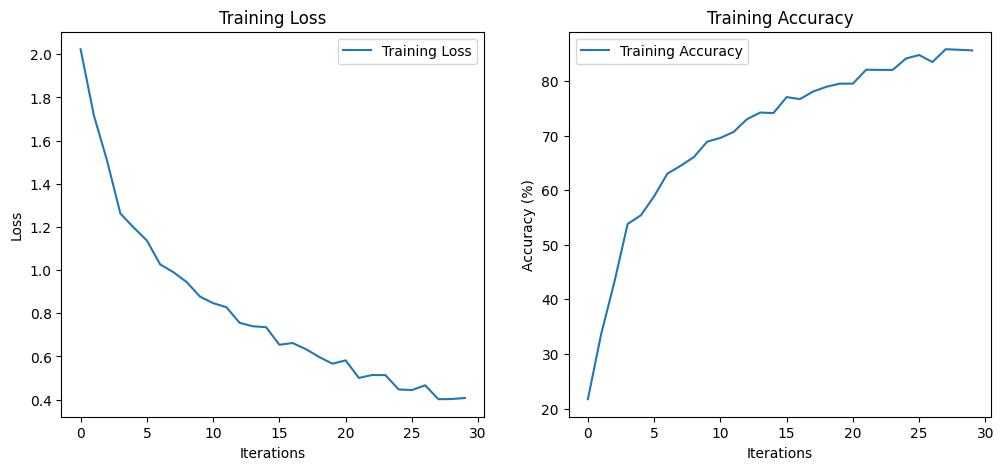

In [ ]:
# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # Normalize for 3 channels

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Adjust the CNN architecture to handle 3 channel input
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)  # Changed from 1 to 3 to handle RGB channels
        #self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        #self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        #self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        #self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Prepare to collect data for analysis
epoch_durations = []
test_duration = 0

# Step 5: Train the network
train_losses = []
train_accuracy = []
start_time = time.time()

for epoch in range(10):
    epoch_start = time.time()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses.append(avg_loss)
            train_accuracy.append(accuracy)
            running_loss = 0.0
            correct = 0
            total = 0
    epoch_durations.append(time.time() - epoch_start)

total_training_time = time.time() - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')

# Step 6: Evaluate the network on the test data
test_start = time.time()

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_duration = time.time() - test_start
print(f'Test Duration: {test_duration:.2f} seconds')
print(f'Accuracy of the network on the 10,000 test images: {100 * correct / total}%')

# Number of parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total Parameters: {total_params}')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

#실습 과제 4.
Lab 3 Transfer Learning 실습에서 ResNet18의 (i) learnable parameters을 고
정한 경우와 (ii) 마지막 3개 Layer만 제외하고 나머지 learnable parameters를 고정한 경
우, (iii) 모든 레이어를 고정하지 않은 경우에 대해 학습시키고 결과를 논의하세요.

(i)learnable parameter를 고정한 경우

100%|██████████| 170498071/170498071 [00:05<00:00, 32071833.32it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s]


Epoch 1, Batch 200, Loss: 1.193, Accuracy: 63.12%
Epoch 1, Batch 400, Loss: 0.756, Accuracy: 75.20%
Epoch 1, Batch 600, Loss: 0.686, Accuracy: 76.88%
Epoch 1 - Training Loss: 0.848, Accuracy: 77.68%, Validation Loss: 0.627, Accuracy: 78.80%
Epoch 2, Batch 200, Loss: 0.637, Accuracy: 78.88%
Epoch 2, Batch 400, Loss: 0.613, Accuracy: 79.00%
Epoch 2, Batch 600, Loss: 0.625, Accuracy: 78.30%
Epoch 2 - Training Loss: 0.625, Accuracy: 77.89%, Validation Loss: 0.593, Accuracy: 79.94%
Epoch 3, Batch 200, Loss: 0.594, Accuracy: 79.34%
Epoch 3, Batch 400, Loss: 0.588, Accuracy: 79.42%
Epoch 3, Batch 600, Loss: 0.599, Accuracy: 79.49%
Epoch 3 - Training Loss: 0.592, Accuracy: 79.83%, Validation Loss: 0.575, Accuracy: 80.50%
Epoch 4, Batch 200, Loss: 0.581, Accuracy: 79.70%
Epoch 4, Batch 400, Loss: 0.581, Accuracy: 80.46%
Epoch 4, Batch 600, Loss: 0.582, Accuracy: 79.74%
Epoch 4 - Training Loss: 0.579, Accuracy: 80.29%, Validation Loss: 0.568, Accuracy: 80.28%
Epoch 5, Batch 200, Loss: 0.578, Acc

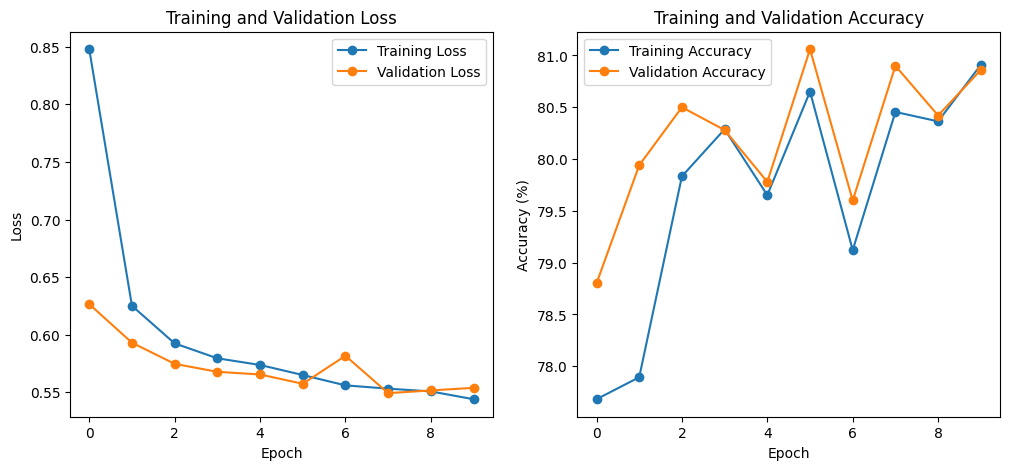

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
import time

start_time = time.time()

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Same stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


# Step 2: Define the CNN architecture with pretrained resnet18
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all the layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = False

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    net.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation step
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

    #epoch_duration = time.time() - start_time
    #print(f"Duration of epoch {epoch+1}: {epoch_duration:.2f} seconds")
    #start_time = time.time()  # Reset the timer for the next epoch

total_training_time = time.time() - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')
print('Finished Training')

# Step 6: Evaluate the network on the test data
inference_start_time = time.time()

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
inference_duration = time.time() - inference_start_time
print(f'Inference Time: {inference_duration:.2f} seconds')
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Count total trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {total_params}')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


(ii)마지막 3개 제외하고 고정한 경우

In [ ]:
for name, param in net.named_parameters():  # named_parameters 가중치 뽑아주는 함수

    print(i,name)
    i+= 1

703 resnet.conv1.weight
704 resnet.bn1.weight
705 resnet.bn1.bias
706 resnet.layer1.0.conv1.weight
707 resnet.layer1.0.bn1.weight
708 resnet.layer1.0.bn1.bias
709 resnet.layer1.0.conv2.weight
710 resnet.layer1.0.bn2.weight
711 resnet.layer1.0.bn2.bias
712 resnet.layer1.1.conv1.weight
713 resnet.layer1.1.bn1.weight
714 resnet.layer1.1.bn1.bias
715 resnet.layer1.1.conv2.weight
716 resnet.layer1.1.bn2.weight
717 resnet.layer1.1.bn2.bias
718 resnet.layer2.0.conv1.weight
719 resnet.layer2.0.bn1.weight
720 resnet.layer2.0.bn1.bias
721 resnet.layer2.0.conv2.weight
722 resnet.layer2.0.bn2.weight
723 resnet.layer2.0.bn2.bias
724 resnet.layer2.0.downsample.0.weight
725 resnet.layer2.0.downsample.1.weight
726 resnet.layer2.0.downsample.1.bias
727 resnet.layer2.1.conv1.weight
728 resnet.layer2.1.bn1.weight
729 resnet.layer2.1.bn1.bias
730 resnet.layer2.1.conv2.weight
731 resnet.layer2.1.bn2.weight
732 resnet.layer2.1.bn2.bias
733 resnet.layer3.0.conv1.weight
734 resnet.layer3.0.bn1.weight
735 resn

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 200, Loss: 0.777, Accuracy: 72.88%
Epoch 1, Batch 400, Loss: 0.529, Accuracy: 82.05%
Epoch 1, Batch 600, Loss: 0.470, Accuracy: 83.89%
Epoch 1 - Training Loss: 0.567, Accuracy: 85.76%, Validation Loss: 0.686, Accuracy: 79.28%
Epoch 2, Batch 200, Loss: 0.351, Accuracy: 87.97%
Epoch 2, Batch 400, Loss: 0.333, Accuracy: 88.45%
Epoch 2, Batch 600, Loss: 0.316, Accuracy: 89.30%
Epoch 2 - Training Loss: 0.334, Accuracy: 88.82%, Validation Loss: 0.391, Accuracy: 87.16%
Epoch 3, Batch 200, Loss: 0.207, Accuracy: 92.77%
Epoch 3, Batch 400, Loss: 0.241, Accuracy: 92.02%
Epoch 3, Batch 600, Loss: 0.247, Accuracy: 91.55%
Epoch 3 - Training Loss: 0.232, Accuracy: 92.06%, Validation Loss: 0.321, Accuracy: 89.10%
Epoch 4, Batch 200, Loss: 0.170, Accuracy: 94.19%
Epoch 4, Batch 400, Loss: 0.170, Accuracy: 94.11%
Epoch 4, Batch 600, Loss: 0.178, Accuracy: 93.87%
Epoch 4 - Training Loss: 0.176, Accuracy: 93.12%, Validation Loss: 0.387, Accuracy: 87.98%
Epoch 5, Batch 200, Loss: 0.117, Acc

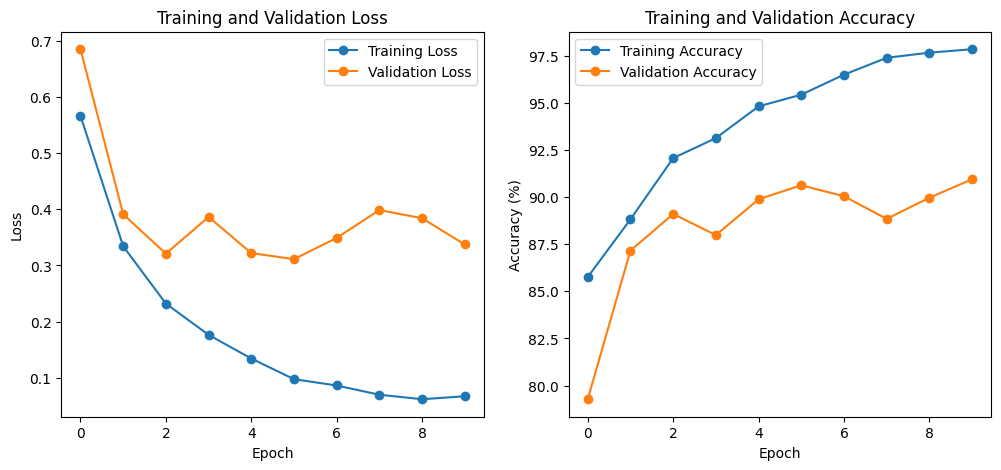

In [ ]:
start_time = time.time()

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Same stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


# Step 2: Define the CNN architecture with pretrained resnet18
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # 마지막 세 레이어 제외하고 모든 레이어의 가중치 고정
        for name, param in net.named_parameters():
            if "layer4.1." not in name and "fc" not in name:
                param.requires_grad = False


        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    net.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation step
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

    #epoch_duration = time.time() - start_time
    #print(f"Duration of epoch {epoch+1}: {epoch_duration:.2f} seconds")
    #start_time = time.time()  # Reset the timer for the next epoch

total_training_time = time.time() - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')
print('Finished Training')

# Step 6: Evaluate the network on the test data
inference_start_time = time.time()

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
inference_duration = time.time() - inference_start_time
print(f'Inference Time: {inference_duration:.2f} seconds')
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Count total trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {total_params}')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

(iii)아무것도 고정하지 않은 경우

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 200, Loss: 0.759, Accuracy: 74.36%
Epoch 1, Batch 400, Loss: 0.545, Accuracy: 81.28%
Epoch 1, Batch 600, Loss: 0.476, Accuracy: 84.02%
Epoch 1 - Training Loss: 0.571, Accuracy: 84.80%, Validation Loss: 0.398, Accuracy: 86.36%
Epoch 2, Batch 200, Loss: 0.330, Accuracy: 88.59%
Epoch 2, Batch 400, Loss: 0.328, Accuracy: 88.85%
Epoch 2, Batch 600, Loss: 0.328, Accuracy: 88.78%
Epoch 2 - Training Loss: 0.328, Accuracy: 89.35%, Validation Loss: 0.326, Accuracy: 89.46%
Epoch 3, Batch 200, Loss: 0.256, Accuracy: 90.98%
Epoch 3, Batch 400, Loss: 0.224, Accuracy: 92.23%
Epoch 3, Batch 600, Loss: 0.233, Accuracy: 92.05%
Epoch 3 - Training Loss: 0.237, Accuracy: 92.15%, Validation Loss: 0.312, Accuracy: 89.60%
Epoch 4, Batch 200, Loss: 0.138, Accuracy: 95.23%
Epoch 4, Batch 400, Loss: 0.176, Accuracy: 94.00%
Epoch 4, Batch 600, Loss: 0.177, Accuracy: 93.95%
Epoch 4 - Training Loss: 0.168, Accuracy: 93.12%, Validation Loss: 0.333, Accuracy: 89.64%
Epoch 5, Batch 200, Loss: 0.117, Acc

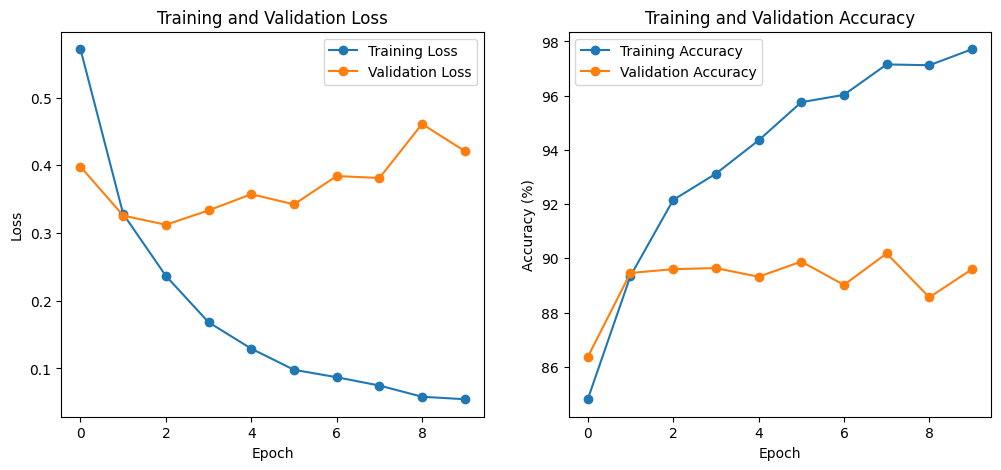

In [ ]:
start_time = time.time()

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Same stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


# Step 2: Define the CNN architecture with pretrained resnet18
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 5: Train the network and validate every epoch
train_losses = []
train_accuracy = []
train_losses_iter = []
train_accuracy_iter = []
val_losses = []
val_accuracy = []

for epoch in range(10):
    running_loss_iter = 0.0
    running_loss = 0.0
    correct = 0
    total = 0
    net.train()
    for i, data in enumerate(trainloader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_loss_iter += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 200 == 199:  # print and record every 200 mini-batches
            avg_loss = running_loss_iter / 200
            accuracy = 100 * correct / total
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
            train_losses_iter.append(avg_loss)
            train_accuracy_iter.append(accuracy)
            running_loss_iter = 0.0
            correct = 0
            total = 0

    train_losses.append(running_loss / len(trainloader))
    train_accuracy.append(100 * correct / total)

    # Validation step
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracy.append(100 * correct / total)

    print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

    #epoch_duration = time.time() - start_time
    #print(f"Duration of epoch {epoch+1}: {epoch_duration:.2f} seconds")
    #start_time = time.time()  # Reset the timer for the next epoch

total_training_time = time.time() - start_time
print(f'Total Training Time: {total_training_time:.2f} seconds')
print('Finished Training')

# Step 6: Evaluate the network on the test data
inference_start_time = time.time()

correct = 0
total = 0
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
inference_duration = time.time() - inference_start_time
print(f'Inference Time: {inference_duration:.2f} seconds')
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Count total trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total Trainable Parameters: {total_params}')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, '-o',label='Training Loss')
plt.plot(val_losses, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy,  '-o',label='Training Accuracy')
plt.plot(val_accuracy, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()